## Notebook contents: logistic regression, DDM, and HMM models fit to 2ABT data
### To be implemented:
1. Cross validation for Logistic regression hyperparameters
2. Multi-state HMM
3. Timeout consideration for head-fixed datasets
4. By-mouse comparison for fit parameters / evaluation of models
5. Proper LL comparison

In [86]:
# run in 3.9.6 64 bit global envir

import os
import numpy as np
import pandas as pd
import sys
import getpass
import seaborn as sns
username=getpass.getuser()
from sklearn.model_selection import train_test_split

import plot_models_v_mouse as bp
import model_policies as models
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit
import matplotlib

# Load in data and grab subset for analysis (MICE)

In [87]:
data_path =  f'/Users/{username}/Dropbox (HMS)/2ABT_Celia/jax_ff_ko/lynne_no_thresh_full_1_jax_ff_ko.csv'

data=pd.read_csv(data_path, index_col=0)
data = data.rename(columns={'Session ID':'Session', 'Higher p port':'highPort', 'Block Trial':'blockTrial'})

In [88]:
data

,Trial,blockTrial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,1_trialDuration,Switch,...,Reward,Mouse ID,Session,Condition,laser_stim,Target,Block ID,Current Block Length,session_pos,treatment
0,2,2,6.707,1.024,1,1,0,2.562,1.445,0,...,0,S1355,S1355_03172022,95-05,0,0,1.0,46,0.009852,jax
1,3,3,1.646,2.080,1,1,0,6.707,1.024,0,...,0,S1355,S1355_03172022,95-05,0,0,1.0,46,0.014778,jax
2,4,4,1.672,1.270,0,1,0,1.646,2.080,1,...,1,S1355,S1355_03172022,95-05,0,0,1.0,46,0.019704,jax
3,5,5,6.881,1.256,1,0,1,1.672,1.270,1,...,0,S1355,S1355_03172022,95-05,0,0,1.0,46,0.024631,jax
4,6,6,2.106,1.445,0,1,0,6.881,1.256,1,...,1,S1355,S1355_03172022,95-05,0,0,1.0,46,0.029557,jax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22234,226,36,15.354,1.263,0,0,1,17.039,1.385,0,...,1,S1473,S1473_07132022,95-05,0,0,6.0,40,0.982609,ff
22235,227,37,7.926,1.461,0,0,1,15.354,1.263,0,...,1,S1473,S1473_07132022,95-05,0,0,6.0,40,0.986957,ff
22236,228,38,4.943,1.198,1,0,1,7.926,1.461,1,...,0,S1473,S1473_07132022,95-05,0,0,6.0,40,0.991304,ff
22237,229,39,2.717,1.245,0,1,0,4.943,1.198,1,...,1,S1473,S1473_07132022,95-05,0,0,6.0,40,0.995652,ff


In [89]:
# post hoc add column for treatment

# data=pd.read_csv(data_path, index_col=0)
# 
# tetanus = ['S1338', 'S1339', 'S1340', 'S1341']
# control = ['WT51', 'WT61', 'WT43', 'WT44', 'WT53', 'WT54', 'WT55', 'WT56']

# data.loc[data['Mouse ID'].isin(control), 'treatment'] = 'mCherry'
# data.loc[data['Mouse ID'].isin(tetanus), 'treatment'] = 'Tetanus'


In [90]:
# P(high)-P(low)
# probs='90-10' 

# history length for conditional probabilites
seq_nback= 2

# for splitting sessions into train and test
train_prop=0.7

# set seed for reproducibility
seed = np.random.randint(1000) 

# treatment_group = 'mcherry'
# data = data.loc[data.treatment==treatment_group]

# data = data.loc[(data.Condition==probs) & (data.treatment==treatment_group)]

In [91]:
data['block_pos_rev'] = data['blockTrial'] - data['Current Block Length'] # reverse block position from transition
data['model']='mouse'

data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

model_summary = pd.DataFrame() 

for mouse in data['Mouse ID'].unique():
    print(f'starting run {mouse}')
    mouse_features = [[data[data.Session==session].Decision.values.astype('int'), \
                    data[data.Session==session].Reward.values.astype('int')] for session in data.loc[data['Mouse ID']==mouse].Session.unique()]
    
    params, nll = fit.fit_with_sgd(fit.log_probability_rflr, mouse_features) # quick fit on RFLR parameters

    a, b, t = params

    model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),
                                         'treatment':data.loc[data['Mouse ID']==mouse].treatment.unique().item()}, ignore_index=True)

starting run S1355
iteration  0 neg ll:  0.4076333
iteration  2500 neg ll:  0.36608526
iteration  5000 neg ll:  0.36607844
iteration  7500 neg ll:  0.3660782


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1356
iteration  0 neg ll:  0.3465727
iteration  2500 neg ll:  0.27941778
iteration  5000 neg ll:  0.2793258
iteration  7500 neg ll:  0.27932534


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1357
iteration  0 neg ll:  0.3543479
iteration  2500 neg ll:  0.32401314
iteration  5000 neg ll:  0.32398564
iteration  7500 neg ll:  0.32398558


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1358
iteration  0 neg ll:  0.4067396
iteration  2500 neg ll:  0.33439162
iteration  5000 neg ll:  0.33435836
iteration  7500 neg ll:  0.33435822


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1399
iteration  0 neg ll:  0.3802507
iteration  2500 neg ll:  0.33407938
iteration  5000 neg ll:  0.33406797
iteration  7500 neg ll:  0.334068


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1400
iteration  0 neg ll:  0.3936537
iteration  2500 neg ll:  0.3579662
iteration  5000 neg ll:  0.35794488
iteration  7500 neg ll:  0.357945


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1401
iteration  0 neg ll:  0.5839234
iteration  2500 neg ll:  0.52884746
iteration  5000 neg ll:  0.52884287
iteration  7500 neg ll:  0.528841


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1374
iteration  0 neg ll:  0.36982822
iteration  2500 neg ll:  0.2919064
iteration  5000 neg ll:  0.29185432
iteration  7500 neg ll:  0.29185453


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1376
iteration  0 neg ll:  0.39137852
iteration  2500 neg ll:  0.30151057
iteration  5000 neg ll:  0.30146262
iteration  7500 neg ll:  0.30146223


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1416
iteration  0 neg ll:  0.43818116
iteration  2500 neg ll:  0.3868097
iteration  5000 neg ll:  0.38680434
iteration  7500 neg ll:  0.38680473


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1417
iteration  0 neg ll:  0.3647746
iteration  2500 neg ll:  0.31935683
iteration  5000 neg ll:  0.3193386
iteration  7500 neg ll:  0.31933916


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1418
iteration  0 neg ll:  0.31109214
iteration  2500 neg ll:  0.28939906
iteration  5000 neg ll:  0.2893785
iteration  7500 neg ll:  0.28937852


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1419
iteration  0 neg ll:  0.41686726
iteration  2500 neg ll:  0.3273089
iteration  5000 neg ll:  0.3272847
iteration  7500 neg ll:  0.3272845


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1420
iteration  0 neg ll:  0.27152076
iteration  2500 neg ll:  0.24097057
iteration  5000 neg ll:  0.24091232
iteration  7500 neg ll:  0.24091214


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1421
iteration  0 neg ll:  0.24341457
iteration  2500 neg ll:  0.1992632
iteration  5000 neg ll:  0.19906883
iteration  7500 neg ll:  0.19906768


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1422
iteration  0 neg ll:  0.27021262
iteration  2500 neg ll:  0.24516311
iteration  5000 neg ll:  0.2450846
iteration  7500 neg ll:  0.2450844


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1459
iteration  0 neg ll:  0.4596235
iteration  2500 neg ll:  0.37652662
iteration  5000 neg ll:  0.37633383
iteration  7500 neg ll:  0.37633377


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1460
iteration  0 neg ll:  0.46538505
iteration  2500 neg ll:  0.3856076
iteration  5000 neg ll:  0.38560143
iteration  7500 neg ll:  0.38560104


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1461
iteration  0 neg ll:  0.3882828
iteration  2500 neg ll:  0.35739067
iteration  5000 neg ll:  0.35737485
iteration  7500 neg ll:  0.35737434


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1462
iteration  0 neg ll:  0.39844695
iteration  2500 neg ll:  0.3498114
iteration  5000 neg ll:  0.34978253
iteration  7500 neg ll:  0.34978157


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1471
iteration  0 neg ll:  0.58616203
iteration  2500 neg ll:  0.44365332
iteration  5000 neg ll:  0.44363615
iteration  7500 neg ll:  0.44363603


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1472
iteration  0 neg ll:  0.47205225
iteration  2500 neg ll:  0.4111166
iteration  5000 neg ll:  0.41110218
iteration  7500 neg ll:  0.41110215


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


starting run S1473
iteration  0 neg ll:  0.5426427
iteration  2500 neg ll:  0.4023103
iteration  5000 neg ll:  0.40228644
iteration  7500 neg ll:  0.40228647


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/1911576206.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),


In [92]:
model_summary

,Mouse,alpha,beta,tau,lls_ddm,treatment
0,S1355,-0.264051,1.941812,0.873360,-0.3660782,jax
1,S1356,-0.831382,3.188510,0.532994,-0.27932566,jax
2,S1357,-0.085504,2.501530,0.484798,-0.32398558,jax
3,S1358,-0.833137,2.524559,0.784763,-0.33435822,jax
4,S1399,-0.313697,2.714175,0.432990,-0.334068,jax
5,S1400,-0.079487,2.335382,0.569295,-0.357945,jax
6,S1401,0.203166,0.878567,1.235303,-0.5288405,jax
7,S1374,-0.966930,3.021040,0.661975,-0.29185456,jax
8,S1376,-1.101993,3.176233,0.592761,-0.30146223,jax
9,S1416,-0.337324,2.425874,0.455282,-0.38680473,ko


In [93]:
model_summary = model_summary.sort_values('treatment', ascending=True) 
model_summary.reset_index(drop=True, inplace=True)
model_summary

,Mouse,alpha,beta,tau,lls_ddm,treatment
0,S1473,-1.345470,2.874388,0.555786,-0.40228647,ff
1,S1462,-0.246130,2.816460,0.123587,-0.34978044,ff
2,S1460,-0.632342,2.709972,0.455745,-0.38560104,ff
3,S1421,-0.129373,3.336737,0.522889,-0.19906762,ff
4,S1419,-0.939737,3.141168,0.483381,-0.3272845,ff
5,S1417,-0.353566,2.797525,0.429279,-0.31933916,ff
6,S1376,-1.101993,3.176233,0.592761,-0.30146223,jax
7,S1355,-0.264051,1.941812,0.873360,-0.3660782,jax
8,S1401,0.203166,0.878567,1.235303,-0.5288405,jax
9,S1400,-0.079487,2.335382,0.569295,-0.357945,jax


/var/folders/92/m8dxyprj3wz2_pky27khyvxc0000gn/T/ipykernel_787/3819962291.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)


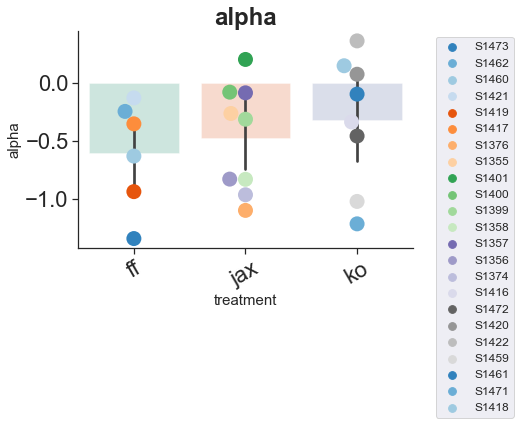

In [94]:
import matplotlib.pyplot as plt

sns.set(style='ticks', font_scale=2, rc={'axes.labelsize':15, 'axes.titlesize':15, 'axes.titleweight':'bold',\
                                         'axes.titlesize':25,'font.weight':'normal'}) 

palette = sns.color_palette("tab20c", len(model_summary))

fig, ax = plt.subplots(figsize=(6,4))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

sns.swarmplot(x='treatment', y='alpha', data=model_summary, palette = palette, hue = 'Mouse', s = 15)
sns.barplot(x='treatment', y='alpha', data=model_summary, palette = "Set2", alpha=0.35)

# plt.xlabel('mice', fontsize = 15)
# plt.ylabel('time (sec)', fontsize = 15)

sns.set(font_scale = 2)
sns.despine()
plt.title('alpha', fontweight = "bold")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 12})

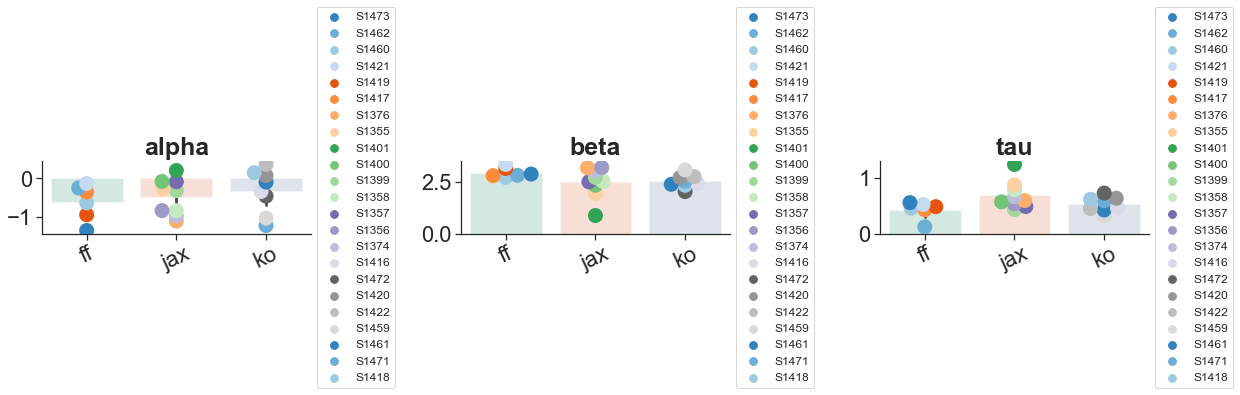

In [95]:
cols = ['alpha', 'beta', 'tau']

sns.set(style='ticks', font_scale=2, rc={'axes.labelsize':10, 'axes.titlesize':15, 'axes.titleweight':'bold',\
                                         'axes.titlesize':25,'font.weight':'normal'}) 

fig, axs = plt.subplots(nrows=int(np.ceil(len(cols)/3)), ncols=3, figsize=(6*3, 4*int(np.ceil(len(cols)/3))))

# gradient color coding:
# palette = sns.light_palette("seagreen", reverse=False,  n_colors=len(mice))

palette = sns.color_palette("tab20c", len(model_summary))

for ax, col in zip(axs.reshape(-1), cols):
   
    sns.swarmplot(x='treatment', y=col, data=model_summary, palette = palette, hue = 'Mouse', s = 15, ax=ax)
    # x = 'treatment' if we are tagging mice by a different classification in this column
    sns.barplot(x='treatment', y=col, data=model_summary, palette = "Set2", alpha=0.3, ax=ax)

    ax.set(xlabel='', ylabel='', title=col)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 25)

    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    # ax.get_legend().remove()

sns.despine()
plt.tight_layout()


In [96]:
# plot individual mice for comparison
# ax = sns.swarmplot(x='Mouse', y='alpha', data=model_summary, size = 15)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# sns.despine()

In [97]:
# ax = sns.swarmplot(x='Mouse', y='beta', data=model_summary, size = 15)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# sns.despine()

In [98]:
# ax = sns.swarmplot(x='Mouse', y='tau', data=model_summary, size = 15)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# sns.despine()

In [99]:
# plot multiple groups per stat
# sns.set(style='ticks', font_scale=2, rc={'axes.labelsize':10, 'axes.titlesize':15, 'axes.titleweight':'bold',\
#                                          'axes.titlesize':25,'font.weight':'normal'}) 


# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2*3, 5)) #4*int(np.ceil(len(cols)/3)))

# test_df = pd.melt(full_stats, id_vars=['treatment'], value_vars=['meanITI', 'decisionTime'])
# sns.barplot(x='variable', y='value', data=test_df, hue='treatment', palette = "Set2", alpha=0.3, hue_order=['control', 'tetanus'], ax=axs)
# sns.swarmplot(x='variable', y='value', data=test_df, palette = "Set2", hue = 'treatment', s = 9, hue_order=['control', 'tetanus'], dodge=True, ax=axs)
# # sns.swarmplot(x='variable', y='value', data=test_df, palette = palette, hue = 'treatment', s = 9, hue_order=['jax', 'ff', 'ko'], dodge=True, ax=axs)
# sns.swarmplot(x='variable', y='value', data=test_df, palette = "Set2", hue = 'treatment', s = 10, dodge=True)


# legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
# axs.set_xticklabels(axs.get_xticklabels(),rotation = 35)

# sns.despine()

# plt.tight_layout()
# plt.savefig('mouse_stats3.svg', dpi=200, bbox_inches="tight")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use s

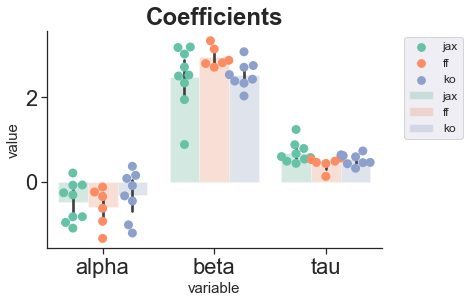

In [100]:
# plotting mice into groups, defined by treatment column
# ------------

tmp = pd.melt(model_summary, id_vars=['Mouse','treatment'], value_vars=['alpha', 'beta', 'tau'])

sns.set(style='ticks', font_scale=2, rc={'axes.labelsize':15, 'axes.titlesize':15, 'axes.titleweight':'bold',\
                                         'axes.titlesize':25,'font.weight':'normal'}) 

palette = sns.color_palette("tab20c", len(model_summary))

fig, ax = plt.subplots(figsize=(6,4))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# sns.barplot(x='variable', y='value', data=tmp, hue='treatment', palette = "Set2", alpha=0.3, hue_order=['control', 'tetanus'])
# sns.swarmplot(x='variable', y='value', data=tmp, palette = "Set2", hue = 'treatment', s = 9, hue_order=['control', 'tetanus'], dodge=True)

sns.barplot(x='variable', y='value', data=tmp, hue='treatment', palette = "Set2", alpha=0.3, hue_order=['jax', 'ff', 'ko'])
sns.swarmplot(x='variable', y='value', data=tmp, palette = "Set2", hue = 'treatment', s = 9, hue_order=['jax', 'ff', 'ko'], dodge=True)

sns.set(font_scale = 2)
sns.despine()
plt.title('Coefficients', fontweight = "bold")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 12})

plt.savefig('model_coeff.svg', dpi=200, bbox_inches="tight")

In [101]:
import scipy 
from scipy import stats

In [108]:
a = tmp.loc[(tmp['treatment'] == 'ko') & (tmp['variable'] == 'alpha')]
b = tmp.loc[(tmp['treatment'] == 'jax') & (tmp['variable'] == 'alpha')]
s = scipy.stats.ranksums(a.loc[:,"value"],b.loc[:,"value"])
print(s.pvalue)
s.pvalue <0.05

0.7003113729368902


False

In [109]:
a = tmp.loc[(tmp['treatment'] == 'ko') & (tmp['variable'] == 'beta')]
b = tmp.loc[(tmp['treatment'] == 'jax') & (tmp['variable'] == 'beta')]
s = scipy.stats.ranksums(a.loc[:,"value"],b.loc[:,"value"])
print(s.pvalue)
s.pvalue <0.05

0.7728299926844475


False

In [110]:
a = tmp.loc[(tmp['treatment'] == 'ko') & (tmp['variable'] == 'tau')]
b = tmp.loc[(tmp['treatment'] == 'jax') & (tmp['variable'] == 'tau')]
s = scipy.stats.ranksums(a.loc[:,"value"],b.loc[:,"value"])
print(s.pvalue)
s.pvalue <0.05

0.17793172526825463


False

In [252]:
# plotting mice into groups, defined by treatment column
# ------------

# tmp = pd.melt(model_summary, id_vars=['Mouse','treatment'], value_vars=['alpha', 'beta', 'tau'])

# sns.set(style='ticks', font_scale=2, rc={'axes.labelsize':15, 'axes.titlesize':15, 'axes.titleweight':'bold',\
#                                          'axes.titlesize':25,'font.weight':'normal'}) 

# palette = sns.color_palette("tab20c", len(model_summary))

# fig, ax = plt.subplots(figsize=(6,6))
# # ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# sns.barplot(x='variable', y='value', data=tmp, hue='treatment', palette = "Set2", alpha=0.3, hue_order=['jax', 'ff', 'ko'])
# # sns.swarmplot(x='variable', y='value', data=tmp, palette = "Set2", hue = 'treatment', s = 9, hue_order=['jax','ff', 'ko'], dodge=True)
# sns.swarmplot(x='variable', y='value', data=tmp, palette = "Set2", hue = 'Mouse', s = 9, dodge = True)

# sns.set(font_scale = 2)
# sns.despine()
# plt.title('Coefficients', fontweight = "bold")
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', prop={'size': 12})

# plt.savefig('model_coeff.svg', dpi=200, bbox_inches="tight")

# Bootstrap coefficients

In [256]:
def resampled_rflr_means(data, col, N=10000, func=np.mean, comparison=False, **kwargs):
# made multiple changes specific to this analysis. main difference is it depends on IDing sessions, whereas in previous bootstrapping this is not required.
    '''

    Resample from data to compute bootstrapped estimates of Column values using given function

    ARGUMENTS:
        data (pd.DataFrame)
        col (str or list): column to perform func on (i.e. to calculate P(Switch))
        N (int): number of repetitions
        func (function): function to apply on column to calculate bootstrapped estimate
        comparison (bool): True if comparing multiple conditions
        **kwargs:
            treatment_col (str): column header with identities of treatment/control classification
            treatment_vals (list): list of ids/labels for assignment to condition group contained within treatment column

    OUTPUTS:
        func_control (list): list of bootstrapped estimates (after resample, on col using func); if comparison is True, 
                             corresponds to control group
        func_treatment (list): as for func_control, for treatment group
        delta (list): pairwise subtraction, func_control - func_treatment

    '''

    import itertools

    func_control = []
    
    if comparison:

        func_treatment = []
        treatment_col = kwargs.get('treatment_col', None)
        control_val = kwargs.get('control_val', None)
        treatment_val = kwargs.get('treatment_val', None)
        # control_val, treatment_val = kwargs.get('treatment_vals', [None, None])


    for i in range(N):

        if i%100==0: print(f'starting run {i}')
        
        all_sessions = data['Session'].unique()
        session_ids = np.random.choice(all_sessions, size=len(all_sessions), replace=True)
        print(len(session_ids))
        resampled_data = pd.concat([data.loc[data['Session']==session] for session in session_ids])
        resample_id = [np.repeat(str(i),len(data.loc[data['Session']==session])) for i,session in enumerate(session_ids)]
        resampled_data['resample_ID'] = list(itertools.chain(*resample_id))
        resampled_data['resample_session'] = resampled_data['Session'] + '_' + resampled_data['resample_ID']

        if comparison:
            resampled_control = resampled_data.loc[resampled_data[treatment_col]==control_val]
            resampled_treatment = resampled_data.loc[resampled_data[treatment_col]==treatment_val]
            # resampled_control = resampled_data.loc[resampled_data[treatment_col].isin(control_val)] # for lists of mice
            # resampled_treatment = resampled_data.loc[resampled_data[treatment_col].isin(treatment_val)] 


            func_control.append(func(resampled_control))
            func_treatment.append(func(resampled_treatment))

        else:
            func_control.append(func(resampled_data))
        
    if comparison:
        return func_control, func_treatment, np.array(func_treatment)-np.array(func_control)

    else:
        return func_control

In [257]:
data['block_pos_rev'] = data['blockTrial'] - data['Current Block Length'] # reverse block position from transition
data['model']='mouse'

data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

model_summary = pd.DataFrame() 

for mouse in data['Mouse ID'].unique():
    print(f'starting run {mouse}')
    mouse_features = [[data[data.Session==session].Decision.values.astype('int'), \
                    data[data.Session==session].Reward.values.astype('int')] for session in data.loc[data['Mouse ID']==mouse].Session.unique()]
    
    params, nll = fit.fit_with_sgd(fit.log_probability_rflr, mouse_features) # quick fit on RFLR parameters

    a, b, t = params

    model_summary = model_summary.append({'Mouse':mouse, 'alpha':a[0], 'beta':b[0], 'tau':t[0], 'lls_ddm':(-nll),
                                        'treatment':data.loc[data['Mouse ID']==mouse].treatment.unique().item()}, ignore_index=True)


starting run S1355
iteration  0 neg ll:  0.4076333
iteration  2500 neg ll:  0.36608526
iteration  5000 neg ll:  0.36607844
iteration  7500 neg ll:  0.3660782
starting run S1356
iteration  0 neg ll:  0.3465727
iteration  2500 neg ll:  0.27941778
iteration  5000 neg ll:  0.2793258
iteration  7500 neg ll:  0.27932534
starting run S1357
iteration  0 neg ll:  0.3543479
iteration  2500 neg ll:  0.32401314
iteration  5000 neg ll:  0.32398564
iteration  7500 neg ll:  0.32398558
starting run S1358
iteration  0 neg ll:  0.4067396
iteration  2500 neg ll:  0.33439162
iteration  5000 neg ll:  0.33435836
iteration  7500 neg ll:  0.33435822
starting run S1399
iteration  0 neg ll:  0.3802507
iteration  2500 neg ll:  0.33407938
iteration  5000 neg ll:  0.33406797
iteration  7500 neg ll:  0.334068
starting run S1400
iteration  0 neg ll:  0.3936537
iteration  2500 neg ll:  0.3579662
iteration  5000 neg ll:  0.35794488
iteration  7500 neg ll:  0.357945
starting run S1401
iteration  0 neg ll:  0.5839234
it

In [258]:
def get_alpha(data):

    mouse_features = [[data[data.resample_session==session].Decision.values.astype('int'), \
                    data[data.resample_session==session].Reward.values.astype('int')] for session in data.resample_session.unique()]

    print(len(mouse_features))
        
    params, nll = fit.fit_with_sgd(fit.log_probability_rflr, mouse_features) # quick fit on RFLR parameters

    a, b, t = params

    return a

In [259]:
def get_beta(data):

    mouse_features = [[data[data.resample_session==session].Decision.values.astype('int'), \
                    data[data.resample_session==session].Reward.values.astype('int')] for session in data.resample_session.unique()]

    print(len(mouse_features))
        
    params, nll = fit.fit_with_sgd(fit.log_probability_rflr, mouse_features) # quick fit on RFLR parameters

    a, b, t = params

    return b

In [260]:
def get_tau(data):

    mouse_features = [[data[data.resample_session==session].Decision.values.astype('int'), \
                    data[data.resample_session==session].Reward.values.astype('int')] for session in data.resample_session.unique()]

    print(len(mouse_features))
        
    params, nll = fit.fit_with_sgd(fit.log_probability_rflr, mouse_features) # quick fit on RFLR parameters

    a, b, t = params

    return t

In [261]:
def plot_dist_with_CI(bootstrapped_dist, label='bootstrapped dist', ax=None):

    import scipy.stats as st

    if ax is None:

        fig, ax = plt.subplots(figsize=(3,3))

    CI_neg, CI_pos = st.norm.interval(alpha=0.95, loc=np.mean(bootstrapped_dist), 
                                    scale=np.std(bootstrapped_dist))

    counts = ax.hist(bootstrapped_dist, label=label)
    
    plt.legend(bbox_to_anchor=(1,1))

    max_count = counts[0].max()
    ax.fill_betweenx(y=[0,max_count+0.5*max_count], x1=CI_neg, x2=CI_pos, alpha=0.6)

    #plt.axvline(x=0, color='k', linewidth = 4)

    sns.despine()

    return ax, max_count

In [276]:
# alpha
control_tau, ttx_tau, delta_tau = resampled_rflr_means(data, col=data.columns, N=100, func=get_alpha, treatment_col='treatment', \
    control_val = 'jax', treatment_val = 'ko', comparison=True) 

starting run 0
87
40
iteration  0 neg ll:  0.4136163
iteration  2500 neg ll:  0.35815454
iteration  5000 neg ll:  0.35813445
iteration  7500 neg ll:  0.3581347
31
iteration  0 neg ll:  0.3680663
iteration  2500 neg ll:  0.3415752
iteration  5000 neg ll:  0.34156385
iteration  7500 neg ll:  0.3415639
87
35
iteration  0 neg ll:  0.37482232
iteration  2500 neg ll:  0.31379718
iteration  5000 neg ll:  0.3137745
iteration  7500 neg ll:  0.31377468
26
iteration  0 neg ll:  0.33644837
iteration  2500 neg ll:  0.30222654
iteration  5000 neg ll:  0.3021993
iteration  7500 neg ll:  0.30219954
87
36
iteration  0 neg ll:  0.3877337
iteration  2500 neg ll:  0.33628625
iteration  5000 neg ll:  0.3362643
iteration  7500 neg ll:  0.33626437
27
iteration  0 neg ll:  0.38566887
iteration  2500 neg ll:  0.3442312
iteration  5000 neg ll:  0.34421328
iteration  7500 neg ll:  0.3442137
87
35
iteration  0 neg ll:  0.37715343
iteration  2500 neg ll:  0.3173835
iteration  5000 neg ll:  0.3173555
iteration  750

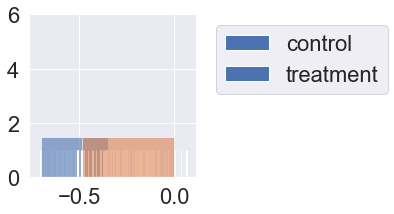

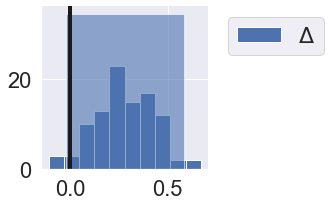

In [277]:
ax, y1 = plot_dist_with_CI(control_tau, label='control')
ax, y2 = plot_dist_with_CI(ttx_tau, label='treatment', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylim([0,np.max((y1,y2))+5])

ax = plot_dist_with_CI(delta_tau, label='$\Delta$')
plt.axvline(x=0, color='k', linewidth = 4)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [278]:
# beta
control_tau, ttx_tau, delta_tau = resampled_rflr_means(data, col=data.columns, N=100, func=get_beta, treatment_col='treatment', \
    control_val = 'jax', treatment_val = 'ko', comparison=True) 

starting run 0
87
36
iteration  0 neg ll:  0.38718182
iteration  2500 neg ll:  0.33197632
iteration  5000 neg ll:  0.33195126
iteration  7500 neg ll:  0.3319511
27
iteration  0 neg ll:  0.39784506
iteration  2500 neg ll:  0.35214788
iteration  5000 neg ll:  0.35213822
iteration  7500 neg ll:  0.35213825
87
25
iteration  0 neg ll:  0.39612758
iteration  2500 neg ll:  0.3330416
iteration  5000 neg ll:  0.333021
iteration  7500 neg ll:  0.33302107
34
iteration  0 neg ll:  0.36385345
iteration  2500 neg ll:  0.33562803
iteration  5000 neg ll:  0.3356163
iteration  7500 neg ll:  0.3356165
87
36
iteration  0 neg ll:  0.4140764
iteration  2500 neg ll:  0.36892116
iteration  5000 neg ll:  0.3689018
iteration  7500 neg ll:  0.36890182
26
iteration  0 neg ll:  0.36965734
iteration  2500 neg ll:  0.33383712
iteration  5000 neg ll:  0.33382323
iteration  7500 neg ll:  0.33382326
87
35
iteration  0 neg ll:  0.37139177
iteration  2500 neg ll:  0.3217355
iteration  5000 neg ll:  0.32171255
iteration 

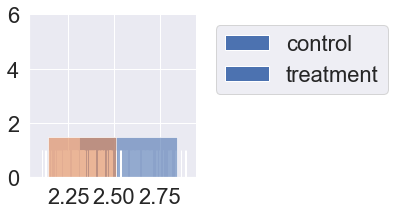

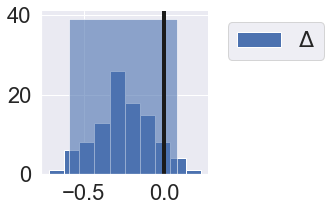

In [279]:
ax, y1 = plot_dist_with_CI(control_tau, label='control')
ax, y2 = plot_dist_with_CI(ttx_tau, label='treatment', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylim([0,np.max((y1,y2))+5])

ax = plot_dist_with_CI(delta_tau, label='$\Delta$')
plt.axvline(x=0, color='k', linewidth = 4)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [280]:
# tau
control_tau, ttx_tau, delta_tau = resampled_rflr_means(data, col=data.columns, N=100, func=get_tau, treatment_col='treatment', \
    control_val = 'jax', treatment_val = 'ko', comparison=True) 

starting run 0
87
36
iteration  0 neg ll:  0.38778886
iteration  2500 neg ll:  0.32747832
iteration  5000 neg ll:  0.32745394
iteration  7500 neg ll:  0.32745415
34
iteration  0 neg ll:  0.36782908
iteration  2500 neg ll:  0.33409372
iteration  5000 neg ll:  0.33407816
iteration  7500 neg ll:  0.33407825
87
32
iteration  0 neg ll:  0.38128823
iteration  2500 neg ll:  0.33127776
iteration  5000 neg ll:  0.3312558
iteration  7500 neg ll:  0.33125597
36
iteration  0 neg ll:  0.4016186
iteration  2500 neg ll:  0.35538837
iteration  5000 neg ll:  0.35537001
iteration  7500 neg ll:  0.35537016
87
32
iteration  0 neg ll:  0.3835143
iteration  2500 neg ll:  0.333941
iteration  5000 neg ll:  0.3339218
iteration  7500 neg ll:  0.33392173
30
iteration  0 neg ll:  0.4081059
iteration  2500 neg ll:  0.36338902
iteration  5000 neg ll:  0.3633769
iteration  7500 neg ll:  0.36337683
87
37
iteration  0 neg ll:  0.40658796
iteration  2500 neg ll:  0.34884867
iteration  5000 neg ll:  0.34882677
iteration

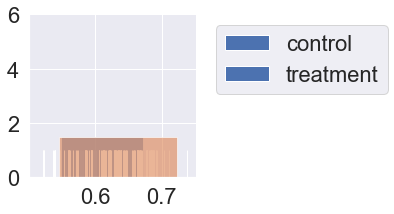

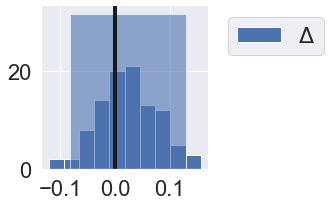

In [281]:
ax, y1 = plot_dist_with_CI(control_tau, label='control')
ax, y2 = plot_dist_with_CI(ttx_tau, label='treatment', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylim([0,np.max((y1,y2))+5])

ax = plot_dist_with_CI(delta_tau, label='$\Delta$')
plt.axvline(x=0, color='k', linewidth = 4)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [282]:
os.system('say "script done"')

0

# Plot mouse behavior vs model

In [ ]:
# get data and add history columns
data['block_pos_rev'] = data['blockTrial'] - data['Current Block Length'] # reverse block position from transition
data['model']='mouse'

data = cprobs.add_history_cols(data, seq_nback) # set history labels up front
data

In [ ]:
# [data[data.Session == session] for session in session_id_list]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for mouse in data['Mouse ID'].unique():

    # split into train and test sets
    train_session_ids, test_session_ids = train_test_split(data['Session'].unique(), 
                                                    train_size=train_prop, random_state=seed) # split full df for train/test

    train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
    test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

    bpos_mouse = bp.get_block_position_summaries(block_pos_core)
    bpos_mouse['condition'] = 'mouse'

    # full dataset for sorting
    df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True, 
                                                            action=['Switch']).sort_values('pswitch')

    df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
    df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
    # bp.plot_sequences(df_mouse_symm, alpha=0.5, title=f'{mouse}') 

    policy = cprobs.calc_conditional_probs(data, symm=False, action=['Decision'])
    models.log_likelihood_empirical_policy(policy, block_pos_core[~block_pos_core['RL_history'].isnull()], seq_nback)

    # RFLG (recursively forumlated logistic regression)

        # params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
        # alpha, beta, tau = params
        # print(f'alpha = {alpha[0]:.2f}')
        # print(f'beta = {beta[0]:.2f}')
        # print(f'tau = {tau[0]:.2f}')

    model_probs = models.RFLR(test_features, params)

    models.log_likelihood_model_policy(model_probs, test_features)

    model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

    # predict action and plot
    block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
    bpos_model = bp.get_block_position_summaries(block_pos_model)
    bpos_model['condition'] = 'model' # label model predictions as such
    bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model), ignore_index=True)
    #bpos_model_v_mouse = bpos_mouse.append(bpos_model, sort=True) # agg df with model predictions and mouse data
    color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}

    symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
    symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
    bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model', title=f'{mouse}')
    plt.savefig('model_syllables3.svg', dpi=200, bbox_inches="tight")

    bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)
    plt.savefig('model_syllables1.svg', dpi=200, bbox_inches="tight")

    bp.plot_scatter(df_mouse_symm, symm_cprobs_model)
    plt.savefig('model_syllables2.svg', dpi=200, bbox_inches="tight")

os.system('say "script done"')


# original code

In [ ]:
# full dataset for sorting
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True, 
                                                        action=['Switch']).sort_values('pswitch')

In [ ]:
data

In [ ]:
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
bp.plot_sequences(df_mouse_symm, alpha=0.5) 
plt.savefig('syllables.svg', dpi=200, bbox_inches="tight")

In [ ]:
df_mouse_symm

In [ ]:
#removing non existent syllables
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
df_mouse_symm = df_mouse_symm.loc[df_mouse_symm.n>15] # filter out any rows where n=0
bp.plot_sequences(df_mouse_symm, alpha=0.5) 
plt.savefig('syllables.svg', dpi=200, bbox_inches="tight")

In [ ]:
policy = cprobs.calc_conditional_probs(data, symm=False, action=['Decision'])
models.log_likelihood_empirical_policy(policy, block_pos_core[~block_pos_core['RL_history'].isnull()], seq_nback)

# Logistic regression

In [ ]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
memories = [L1, 0, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

In [ ]:
models.log_likelihood_model_policy(model_probs, test_features)

# Recursively formulated logistic regression (RFLR)

In [ ]:
data

In [ ]:
# get data and add history columns
data['block_pos_rev'] = data['blockTrial'] - data['Current Block Length'] # reverse block position from transition
data['model']='mouse'

data = cprobs.add_history_cols(data, seq_nback) # set history labels up front
data

In [ ]:
# split into train and test sets
train_session_ids, test_session_ids = train_test_split(data['Session'].unique(), 
                                                train_size=train_prop, random_state=seed) # split full df for train/test

train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

In [ ]:
params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
alpha, beta, tau = params
print(f'alpha = {alpha[0]:.2f}')
print(f'beta = {beta[0]:.2f}')
print(f'tau = {tau[0]:.2f}')

model_probs = models.RFLR(test_features, params)
os.system('say "script done"')

In [ ]:
models.log_likelihood_model_policy(model_probs, test_features)

# Predict action and plot

In [ ]:
# if you make a change to a function and want to test it inline
import importlib
importlib.reload(bp)

In [ ]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = bpos_mouse.append(bpos_model, sort=True) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[1]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)
plt.savefig('syllables2.svg', dpi=200, bbox_inches="tight")
symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model')
plt.savefig('syllables3.svg', dpi=200, bbox_inches="tight")

bp.plot_scatter(df_mouse_symm, symm_cprobs_model)

In [1]:
tau

NameError: name 'tau' is not defined

In [ ]:
sns.despine
evidence_weights = [beta * np.exp(-tau * i) for i in range(10)] 
p_evidence_weights = evidence_weights/sum(evidence_weights) 
plt.plot(p_evidence_weights)
print(sum(p_evidence_weights))
plt.savefig('syllables.svg', dpi=200, bbox_inches="tight")

In [ ]:
p_evidence_weights

In [ ]:
sum(p_evidence_weights[:2])/sum(p_evidence_weights)

In [ ]:
sum(p_evidence_weights)

In [ ]:
cum_weights = np.cumsum(evidence_weights)/sum(evidence_weights)
plt.plot(cum_weights)